In [24]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv


# Problem Description and Data

This Challenge is to develop a model to predict whether a tweet describes a real disaster (label 1) or not (label 0) using the provided dataset. The goal is to assist disaster relief organizations and news agencies in programmatically monitoring Twitter for real-time emergency announcements.

## Problem Context

Twitter is a crucial communication channel during emergencies due to the widespread use of smartphones. People often report emergencies as they observe them, making it essential for agencies to distinguish between actual disaster reports and non-disaster content.

## Dataset Origin

The dataset was created by Figure-Eight and initially shared on their 'Data For Everyone' website.

## Evaluation Metric

The performance of the predictions will be evaluated using the F1 score, which balances precision and recall between the predicted and actual labels.

## Key Challenges
### Ambiguity in Tweets
Tweets can be ambiguous and may not clearly indicate whether they describe a real disaster.

### Text Processing

Effective preprocessing of tweet text to handle slang, abbreviations, and varied linguistic styles is critical.

### Imbalanced Data: There may be an imbalance between disaster-related and non-disaster-related tweets, impacting the model's performance.

## Plans to Address the Problem
### Data Preprocessing:

**Clean** the tweet text by removing special characters, URLs, and irrelevant content.

**Normalize** the text by converting it to lowercase and removing stop words.

**Tokenize and lemmatize/stem** the text to standardize the words.

**Feature Engineering** Extract relevant features such as word n-grams, TF-IDF scores, and sentiment analysis scores.

In [25]:
# Constants

INPUT_DIR = '/kaggle/input/nlp-getting-started'
TRAINING_FILE = '/kaggle/input/nlp-getting-started/train.csv'
TEST_FILE = '/kaggle/input/nlp-getting-started/test.csv'
SUBMISSION_SAMPLE_FILE = '/kaggle/input/nlp-getting-started/sample_submission.csv'
SUBMISSION_FILE = '/kaggle/input/nlp-getting-started/submission.csv'

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, Dropout
from tensorflow.keras.optimizers import Adam

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score

import keras_tuner as kt

In [27]:
start_time = time.time()

In [28]:
# Plot distribution of target
def plot_distribution(data):
    plt.figure(figsize=(6,4))
    sns.countplot(x='target', data=data)
    plt.title('Distribution of Target Variable')
    plt.show()

# Plot length of text distributions
def plot_text_len_distribution(data):
    data['text_length'] = data['text'].apply(len)
    plt.figure(figsize=(10,6))
    sns.histplot(data[data['target'] == 1]['text_length'], bins=30, color='blue', label='Positive')
    sns.histplot(data[data['target'] == 0]['text_length'], bins=30, color='red', label='Negative')
    plt.legend()
    plt.title('Text Length Distribution by Target')
    plt.show()
    
def plot_text_length_distribution(data):
    data['text_length'] = data['text'].apply(len)
    plt.figure(figsize=(10,6))
    sns.histplot(data['text_length'], bins=30, color='blue', label='Text Length')
    plt.legend()
    plt.title('Text Length Distribution')
    plt.show()

In [29]:
# Load dataset
training_df = pd.read_csv(TRAINING_FILE)
test_df = pd.read_csv(TEST_FILE)

## Inspect Training Data

In [30]:
training_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [31]:
training_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


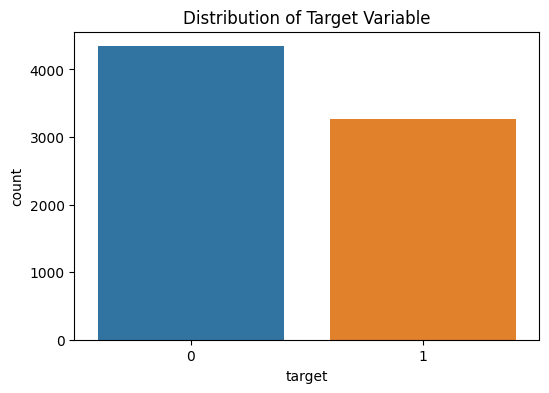

In [32]:
plot_distribution(training_df)

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


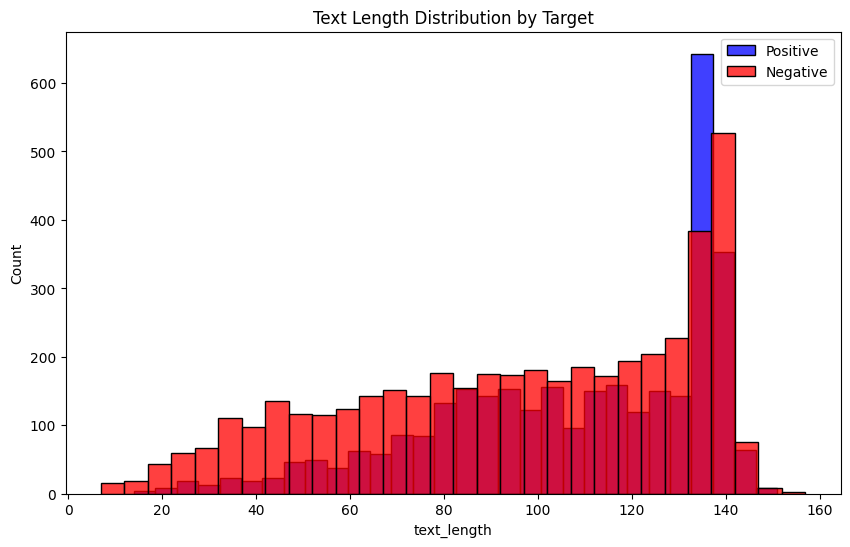

In [33]:
plot_text_len_distribution(training_df)

In [34]:
# Check for missing target
training_df['target'].isna().sum()

0

# Inspect Test Data

In [35]:
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [36]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


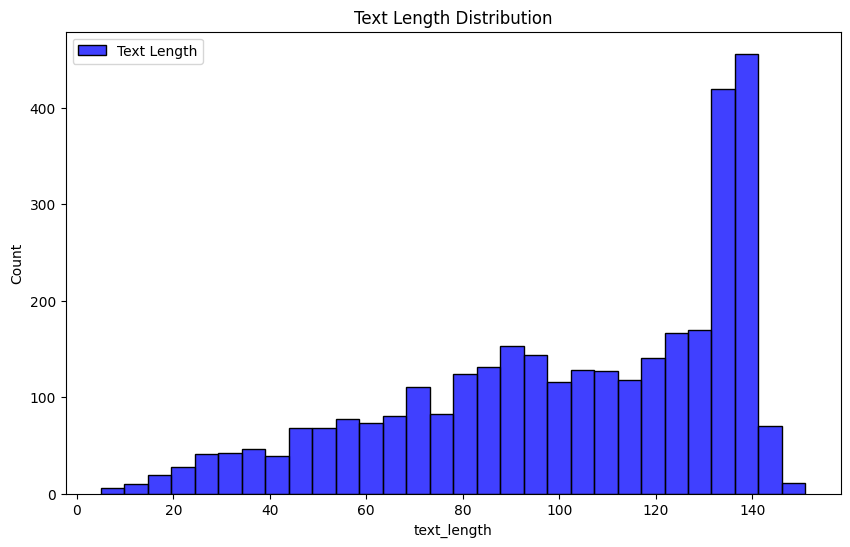

In [37]:
plot_text_length_distribution(test_df)

# Observation
Looks like both test and training data length distributions are similar.  There is not target missing, the training data looks clean.

## Data preprocessing

In [38]:
training_df = training_df.drop(["keyword", "location", "text_length"], axis=1)
test_df = test_df.drop(["keyword", "location", "text_length"], axis=1)

In [39]:
training_df.head()

,id,text,target
0,1,Our Deeds are the Reason of this #earthquake M...,1
1,4,Forest fire near La Ronge Sask. Canada,1
2,5,All residents asked to 'shelter in place' are ...,1
3,6,"13,000 people receive #wildfires evacuation or...",1
4,7,Just got sent this photo from Ruby #Alaska as ...,1


In [40]:
test_df.head()

,id,text
0,0,Just happened a terrible car crash
1,2,"Heard about #earthquake is different cities, s..."
2,3,"there is a forest fire at spot pond, geese are..."
3,9,Apocalypse lighting. #Spokane #wildfires
4,11,Typhoon Soudelor kills 28 in China and Taiwan


In [41]:
# Text preprocessing
stop_words = set(stopwords.words('english'))
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    tokens = word_tokenize(text)
    filtered_tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(filtered_tokens)

def clean_text(data):
    # Remove duplicates
    data.drop_duplicates(subset='text', inplace=True)

    # Remove missing values
    data.dropna(subset=['text'], inplace=True)

    data['text'] = data['text'].apply(preprocess_text)

In [42]:
clean_text(training_df)
clean_text(test_df)

In [43]:
training_df.head()

,id,text,target
0,1,deeds reason earthquake may allah forgive us,1
1,4,forest fire near la ronge sask canada,1
2,5,residents asked shelter place notified officer...,1
3,6,people receive wildfires evacuation orders cal...,1
4,7,got sent photo ruby alaska smoke wildfires pou...,1


## Model Training

### Training with Simple Logistic Regression  

In [44]:
# Plot the confusion matrix
def plot_confusion_matrix(conf_matt):
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matt, annot=True, fmt='d', cmap='Blues', xticklabels=['False', 'True'], yticklabels=['False', 'True'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

In [45]:
# Spliting the data
X_train, X_val, y_train, y_val = train_test_split(training_df['text'], training_df['target'], test_size=0.2, random_state=42)

# Vectorizing the text data using TF-IDF
vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_val_tfidf = vectorizer.transform(X_val)

# Build and train the logistic regression model
model = LogisticRegression()
model.fit(X_train_tfidf, y_train)

# Evaluate the model on validation data
y_val_pred = model.predict(X_val_tfidf)
accuracy_logreg = accuracy_score(y_val, y_val_pred)
f1_logreg = f1_score(y_val, y_val_pred)

# Classification report
print(classification_report(y_val, y_val_pred))

# Confusion matrix
conf_matrix = confusion_matrix(y_val, y_val_pred)
print(conf_matrix)

              precision    recall  f1-score   support

           0       0.78      0.89      0.84       874
           1       0.82      0.66      0.73       627

    accuracy                           0.80      1501
   macro avg       0.80      0.78      0.78      1501
weighted avg       0.80      0.80      0.79      1501

[[781  93]
 [214 413]]


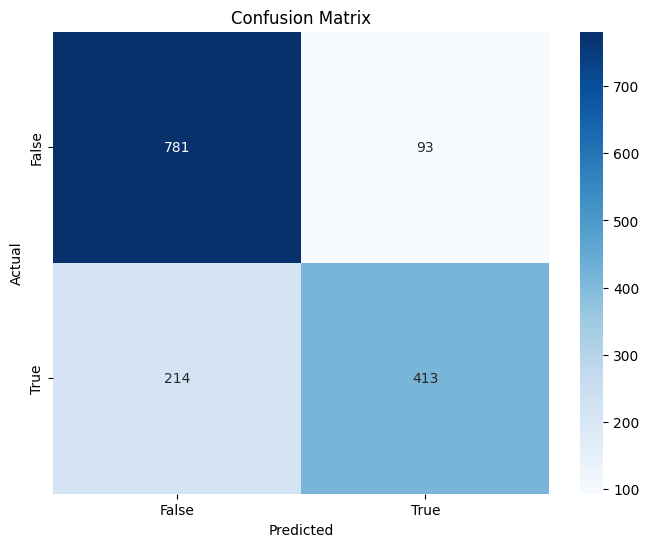

In [46]:
plot_confusion_matrix(conf_matrix)

## LSTM model

LSTMs (Long Short-Term Memory networks) are designed to handle sequential data. They process input sequences one step at a time, maintaining a state that captures information about previous steps.

LSTMs require numerical input, so text data must be converted into numerical sequences. The Tokenizer helps in this conversion by assigning a unique integer to each word in the vocabulary.

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 11s 38ms/step - accuracy: 0.6133 - loss: 0.6352 - val_accuracy: 0.7855 - val_loss: 0.4678
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.9031 - loss: 0.2573 - val_accuracy: 0.7821 - val_loss: 0.5129
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.9660 - loss: 0.1102 - val_accuracy: 0.7582 - val_loss: 0.6545
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.7934 - loss: 0.5666 - val_accuracy: 0.6875 - val_loss: 0.6400
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.9387 - loss: 0.2090 - val_accuracy: 0.7735 - val_loss: 0.7054
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.9667 - loss: 0.1309 - val_accuracy: 0.7668 - val_loss: 0.7420
Epoch 7/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.9727 - loss: 0.0935 - val_accuracy: 0.7508 - val_loss: 0.7007
Epoch 8/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.9777 - loss: 0.0908 - val_accuracy: 0.5170 - 

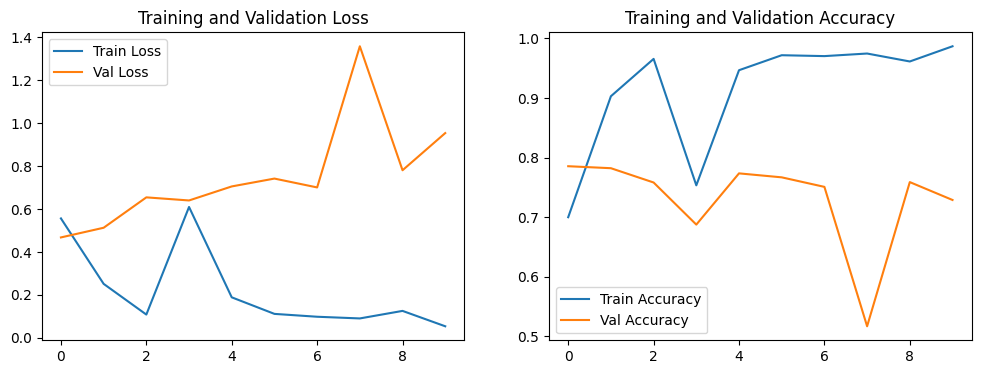

In [47]:
# Tokenization and padding

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
vocab_size = len(tokenizer.word_index) + 1
max_length = 100

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)
X_train_pad = pad_sequences(X_train_seq, maxlen=max_length, padding='post')
X_val_pad = pad_sequences(X_val_seq, maxlen=max_length, padding='post')

# Build the model
model = Sequential()
model.add(Embedding(vocab_size, 100, input_length=max_length))
model.add(Bidirectional(LSTM(128, return_sequences=True)))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(64)))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

# Train the model
history = model.fit(X_train_pad, y_train, epochs=10, validation_data=(X_val_pad, y_val), batch_size=64)

# Evaluate the model on validation data
y_val_pred = (model.predict(X_val_pad) > 0.5).astype("int32")
accuracy_base_lstm = accuracy_score(y_val, y_val_pred)
f1_base_lstm = f1_score(y_val, y_val_pred)

# Classification report
print(classification_report(y_val, y_val_pred))

# Confusion matrix
conf_matrix = confusion_matrix(y_val, y_val_pred)
print(conf_matrix)

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

In [48]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 100, 100)       │     1,851,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 100, 256)       │       234,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 100, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 128)            │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,752,033 (25.76 MB)

 Trainable params: 2,250,677 (8.59 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 4,501,356 (17.17 MB)

# Building another LSTM model for hyperparameter tuning

Trial 30 Complete [00h 00m 24s]
val_accuracy: 0.800133228302002

Best val_accuracy So Far: 0.800133228302002
Total elapsed time: 00h 08m 36s

The hyperparameter search is complete. The optimal number of units in the embedding layer is 200, 
the optimal number of LSTM layers is 1, 
the optimal learning rate for the optimizer is 0.0013483168145598807.

Epoch 1/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.6537 - loss: 0.6169 - val_accuracy: 0.7801 - val_loss: 0.4694
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.9004 - loss: 0.2643 - val_accuracy: 0.7795 - val_loss: 0.5331
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.9670 - loss: 0.1046 - val_accuracy: 0.7588 - val_loss: 0.5585
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.9742 - loss: 0.0977 - val_accuracy: 0.7735 - val_loss: 0.7882
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.9925 - loss: 0.0274 - val_accuracy: 0.7775 - val_loss: 0.9075
Epoch 6/10
9

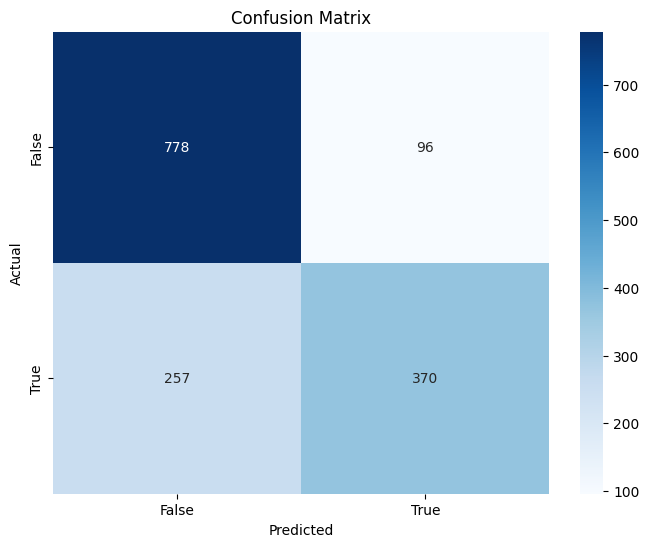

In [49]:
# Define the model
def build_model(hp):
    model = Sequential()
    model.add(Embedding(vocab_size, hp.Int('embedding_dim', 50, 300, step=50), input_length=max_length))
    for i in range(hp.Int('num_layers', 1, 3)):
        model.add(Bidirectional(LSTM(units=hp.Int(f'lstm_units_{i}', 32, 256, step=32), return_sequences=True if i < hp.Int('num_layers', 1, 3) - 1 else False)))
        model.add(Dropout(rate=hp.Float(f'dropout_{i}', 0.2, 0.5, step=0.1)))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=Adam(learning_rate=hp.Float('learning_rate', 1e-4, 1e-2, sampling='LOG')), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Hyperparameter tuning using Keras Tuner
tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=10,
    factor=3,
    directory='my_dir',
    project_name='lstm_tuning'
)

# Run the tuner
tuner.search(X_train_pad, y_train, epochs=10, validation_data=(X_val_pad, y_val), batch_size=64)

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"""
The hyperparameter search is complete. The optimal number of units in the embedding layer is {best_hps.get('embedding_dim')}, 
the optimal number of LSTM layers is {best_hps.get('num_layers')}, 
the optimal learning rate for the optimizer is {best_hps.get('learning_rate')}.
""")
best_hps_values = {
    'embedding_dim': best_hps.get('embedding_dim'),
    'num_layers': best_hps.get('num_layers'),
    'lstm_units': [best_hps.get(f'lstm_units_{i}') for i in range(best_hps.get('num_layers'))],
    'dropout_rates': [best_hps.get(f'dropout_{i}') for i in range(best_hps.get('num_layers'))],
    'learning_rate': best_hps.get('learning_rate')
}

# Build the best model
model = tuner.hypermodel.build(best_hps)
history = model.fit(X_train_pad, y_train, epochs=10, validation_data=(X_val_pad, y_val), batch_size=64)

# Evaluate the model on validation data
y_val_pred = (model.predict(X_val_pad) > 0.5).astype("int32")
accuracy_best_model = accuracy_score(y_val, y_val_pred)
f1_best_model = f1_score(y_val, y_val_pred)

# Classification report
print(classification_report(y_val, y_val_pred))

# Confusion matrix
conf_matrix = confusion_matrix(y_val, y_val_pred)
print(conf_matrix)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['False', 'True'], yticklabels=['False', 'True'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

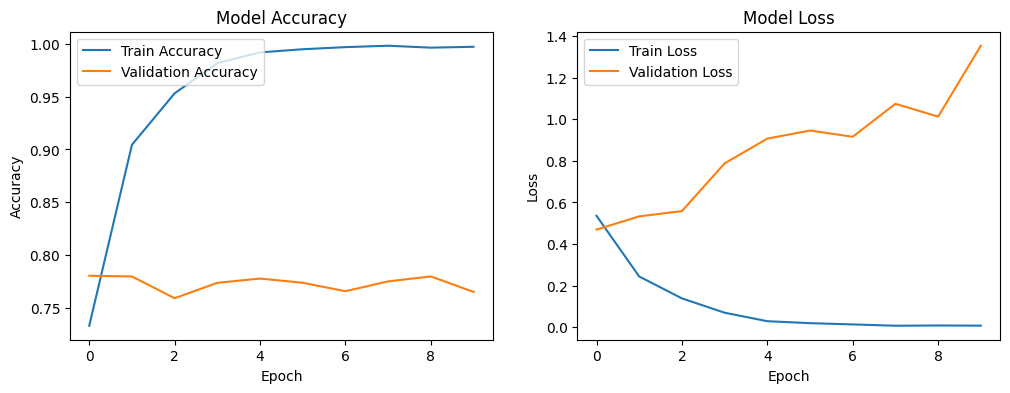

In [50]:
# Plot training & validation accuracy and loss values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

plt.show()

In [51]:
results = pd.DataFrame({
    'Model': ['Logistic Regression', 'Base LSTM', 'Tuned LSTM'],
    'Accuracy': [accuracy_logreg, accuracy_base_lstm, accuracy_best_model],
    'F1 Score': [f1_logreg, f1_base_lstm, f1_best_model],
    'Hyperparameters': [None, None, best_hps_values]
})
results

,Model,Accuracy,F1 Score,Hyperparameters
0,Logistic Regression,0.795470,0.729038,None
1,Base LSTM,0.728847,0.705286,None
2,Tuned LSTM,0.764823,0.677036,"{'embedding_dim': 200, 'num_layers': 1, 'lstm_..."


In [55]:
best_hps_values

{'embedding_dim': 200,
 'num_layers': 1,
 'lstm_units': [160],
 'dropout_rates': [0.30000000000000004],
 'learning_rate': 0.0013483168145598807}

In [52]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 100, 200)       │     3,703,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 320)            │       462,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 320)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           321 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,497,405 (47.67 MB)

 Trainable params: 4,165,801 (15.89 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 8,331,604 (31.78 MB)

In [53]:
end_time = time.time()
print(f'Total Time of execution {end_time - start_time}')

Total Time of execution 589.3816115856171


In [54]:
X_test_seq = tokenizer.texts_to_sequences(test_df['text'])
X_test_pad = pad_sequences(X_test_seq, maxlen=max_length, padding='post')
# Predict on test data using the best model
test_df['target'] = (model.predict(X_test_pad) > 0.5).astype("int32")

# Create submission file
submission = test_df[['id', 'target']]
submission.to_csv('submission.csv', index=False)

102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


# References

- [Text classification with an RNN](https://www.tensorflow.org/text/tutorials/text_classification_rnn)
- [Scikit-Learn LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)
- [TensorFlow v2.16.1 Tokenizer Documentation](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer)
- [Scikit-Lean TfidfVectorizer Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html)
- [Medium Article about TF-IDF](https://medium.com/@cmukesh8688/tf-idf-vectorizer-scikit-learn-dbc0244a911a)
- [TensorFlow Resouce - Tokenizing with TF Text](https://www.tensorflow.org/text/guide/tokenizers)
- [KerasTuner Documentation](https://keras.io/keras_tuner/)
- [Medium Article: Hypertuning a LSTM with Keras Tuner to forecast solar irradiance](https://medium.com/analytics-vidhya/hypertuning-a-lstm-with-keras-tuner-to-forecast-solar-irradiance-7da7577e96eb)
- [Stock Forecasting with LSTM, part 2 Keras Tuner](https://kamran-afzali.github.io/posts/2022-02-20/tuner.html)
- [TensorFlow Learning Resource: Introduction to the Keras Tuner](https://www.tensorflow.org/tutorials/keras/keras_tuner)